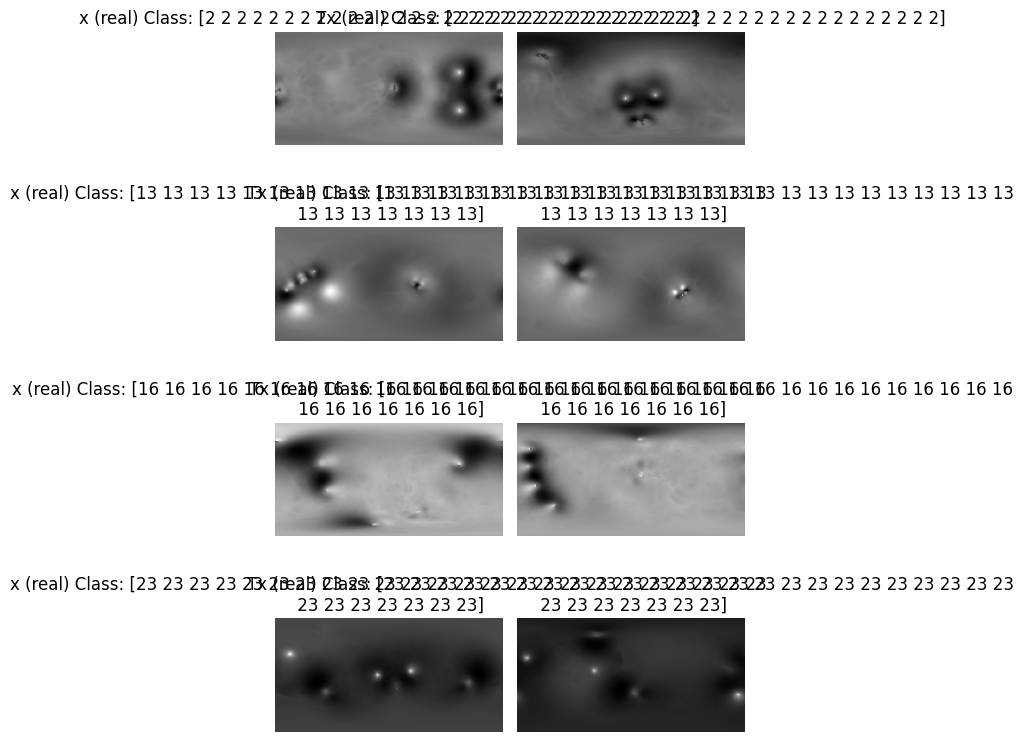

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import os
from data.input_pipeline import get_cshrec11
from data.xforms import draw_shrec11_pairs

# Set the path to your SHREC11 dataset directory
CSHREC11_DIR = "./data/SHREC_11/processed/"  # <-- Change this to your actual path if needed

# Load train data (tf.data.Dataset)
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

# Get a batch of real data
BATCH_SIZE = 4
NUM_SHAPES = 8  # number of shapes per batch (sequence length)

# tf.data pipeline: get a batch as numpy array
for batch in train_data.batch(NUM_SHAPES).take(1):
    # batch is a dict; get the main shape/image tensor (usually 'image', 'shape', or similar)
    # Try common keys
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        # fallback: just use the first key
        data = list(batch.values())[0].numpy()
    # Reshape for compatibility: (batch_size, num_shapes, H, W, C)
    data = np.expand_dims(data, axis=0) if data.ndim == 4 else data  # (N, H, W, C)
    if data.shape[0] < BATCH_SIZE:
        data = np.tile(data, (BATCH_SIZE // data.shape[0] + 1, 1, 1, 1, 1))[:BATCH_SIZE]
    break

# JAX random key
test_key = jax.random.PRNGKey(0)

# Draw pairs
pairs = draw_shrec11_pairs(jnp.array(data), test_key)

# Visualize a few pairs (x, Tx)
num_pairs_to_show = min(4, pairs.shape[0] // 2)
fig, axes = plt.subplots(num_pairs_to_show, 2, figsize=(5, 2 * num_pairs_to_show))
labels = batch.get('label', None)
for i in range(num_pairs_to_show):
    x = pairs[2*i, ...].squeeze()
    Tx = pairs[2*i+1, ...].squeeze()
    label_str = f"Class: {labels[2*i].numpy()}" if labels is not None else ""
    axes[i, 0].imshow(x[..., 0], cmap='gray')
    axes[i, 0].set_title(f'x (real) {label_str}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(Tx[..., 0], cmap='gray')
    axes[i, 1].set_title(f'Tx (real) {label_str}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


In [9]:
print(x.shape)

(96, 192, 16)


Raw data shape: (8, 31, 96, 192, 16)
Data shape: (31, 96, 192, 16) (num_augs, H, W, num_channels)
Available augmentations: 0 to 30
Available channels: 0 to 15


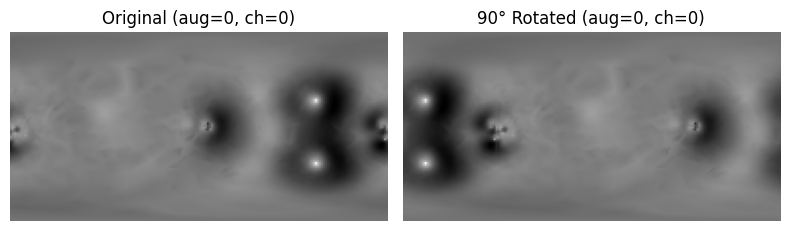

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from data.input_pipeline import get_cshrec11

# Set the path to your SHREC11 dataset directory
CSHREC11_DIR = "./data/SHREC_11/processed/"

# Load train data (tf.data.Dataset)
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

# Get a batch of real data
NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

print("Raw data shape:", data.shape)
if data.ndim == 5:
    # (batch_size, num_augs, H, W, num_channels)
    data = data[0]  # Select the first sample in the batch
elif data.ndim == 4:
    # (num_augs, H, W, num_channels)
    pass
else:
    raise ValueError(f"Unexpected data shape: {data.shape}")

num_augs, H, W, num_channels = data.shape

print(f"Data shape: {data.shape} (num_augs, H, W, num_channels)")

# Interactive selection
def visualize_aug_channel(aug_idx=0, channel_idx=0):
    x = data[aug_idx]  # (H, W, num_channels)
    x_rot = np.roll(x, shift=W//4, axis=1)  # 90 degree rotation
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(x[..., channel_idx], cmap='gray')
    axes[0].set_title(f'Original (aug={aug_idx}, ch={channel_idx})')
    axes[0].axis('off')
    axes[1].imshow(x_rot[..., channel_idx], cmap='gray')
    axes[1].set_title(f'90° Rotated (aug={aug_idx}, ch={channel_idx})')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print(f"Available augmentations: 0 to {num_augs-1}")
    print(f"Available channels: 0 to {num_channels-1}")
    aug_idx = int(input(f"Enter augmentation index [0-{num_augs-1}]: "))
    channel_idx = int(input(f"Enter channel index [0-{num_channels-1}]: "))
    visualize_aug_channel(aug_idx, channel_idx)


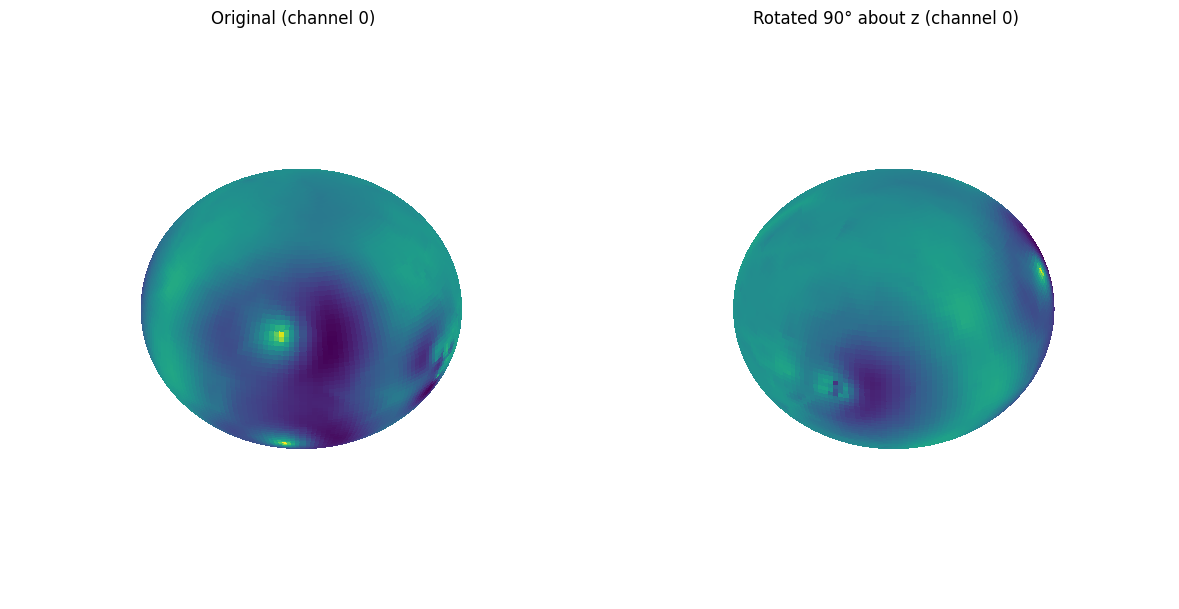

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude: 0 (north pole) to pi (south pole)
phi = np.linspace(0, 2 * np.pi, W)  # longitude: 0 to 2pi
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# 90-degree rotation about z (longitude shift)
def rotate_z(x, angle_deg):
    shift = int(W * angle_deg / 360)
    return np.roll(x, shift=shift, axis=1)

x_rot = rotate_z(x, 90)

# Plot original and rotated on the sphere
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

surf1 = ax1.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x - x.min())/(x.max()-x.min())), rstride=1, cstride=1, antialiased=False, shade=False)
ax1.set_title('Original (channel 0)')
ax1.set_axis_off()

surf2 = ax2.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_rot - x_rot.min())/(x_rot.max()-x_rot.min())), rstride=1, cstride=1, antialiased=False, shade=False)
ax2.set_title('Rotated 90° about z (channel 0)')
ax2.set_axis_off()

plt.tight_layout()
plt.show()


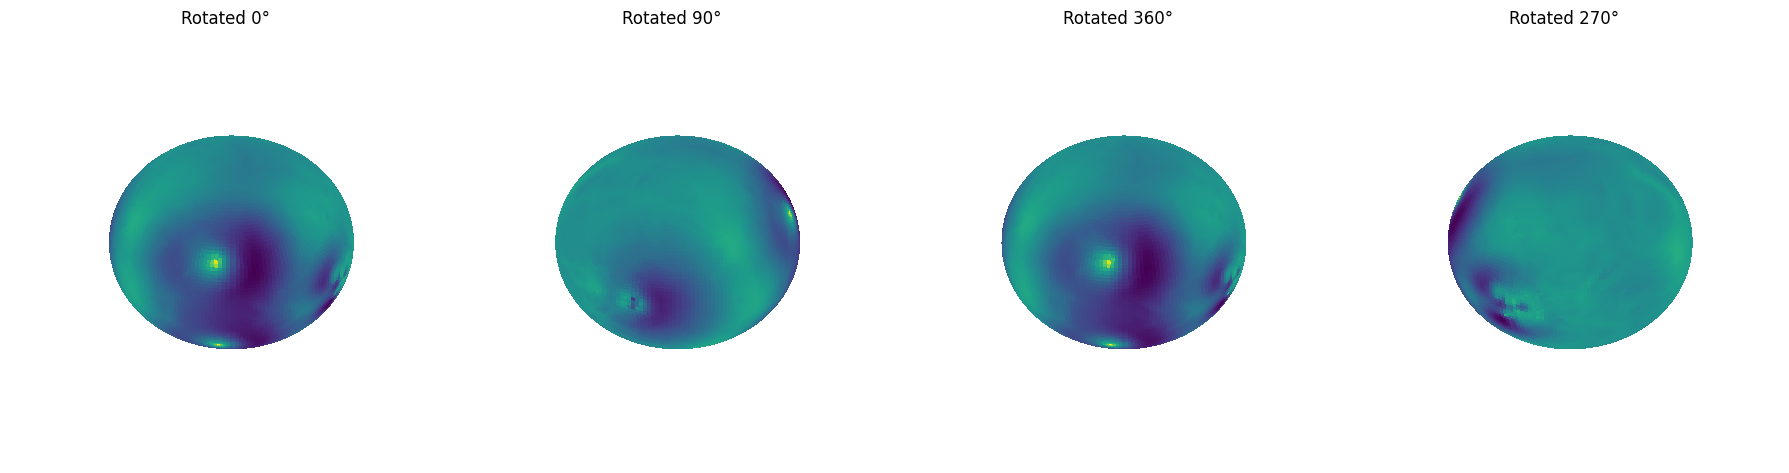

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude: 0 (north pole) to pi (south pole)
phi = np.linspace(0, 2 * np.pi, W)  # longitude: 0 to 2pi
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# Rotation function
def rotate_z(x, angle_deg):
    shift = int(W * angle_deg / 360)
    return np.roll(x, shift=shift, axis=1)

angles = [0, 90, 180, 270]
x_rots = [rotate_z(x, a) for a in angles]

fig = plt.figure(figsize=(18, 5))
for i, (a, x_r) in enumerate(zip(angles, x_rots)):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_r-x_r.min())/(x_r.max()-x_r.min())), rstride=1, cstride=1, antialiased=False, shade=False)
    ax.set_title(f'Rotated {a}\u00b0')
    ax.set_axis_off()
plt.tight_layout()
plt.show()


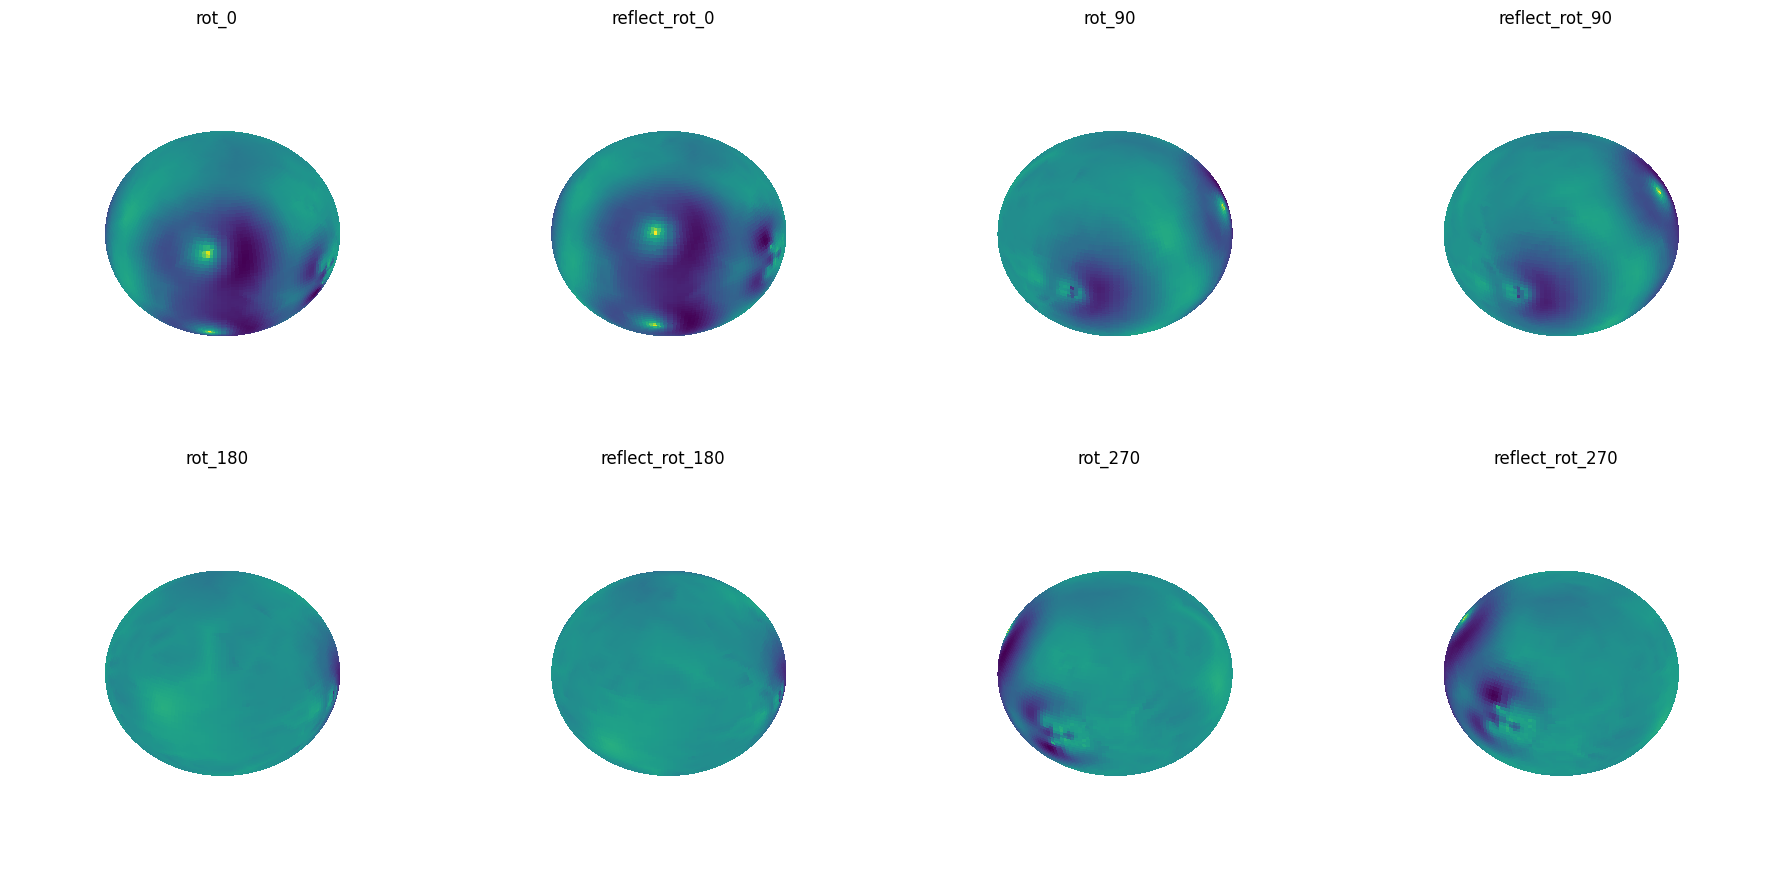

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude
phi = np.linspace(0, 2 * np.pi, W)  # longitude
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# D_n symmetries (n = 4 for 0, 90, 180, 270)
def dn_symmetries(x, n):
    H, W = x.shape
    syms = []
    for k in range(n):
        # Rotation
        rot = np.roll(x, shift=k*W//n, axis=1)
        syms.append((f'rot_{k*360//n}', rot))
        # Reflection + rotation
        refl = np.flip(rot, axis=0)
        syms.append((f'reflect_rot_{k*360//n}', refl))
    return syms

n = 4
syms = dn_symmetries(x, n)

fig = plt.figure(figsize=(18, 9))
for i, (name, x_r) in enumerate(syms):
    ax = fig.add_subplot(2, n, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_r-x_r.min())/(x_r.max()-x_r.min())), rstride=1, cstride=1, antialiased=False, shade=False)
    ax.set_title(name)
    ax.set_axis_off()
plt.tight_layout()
plt.show()


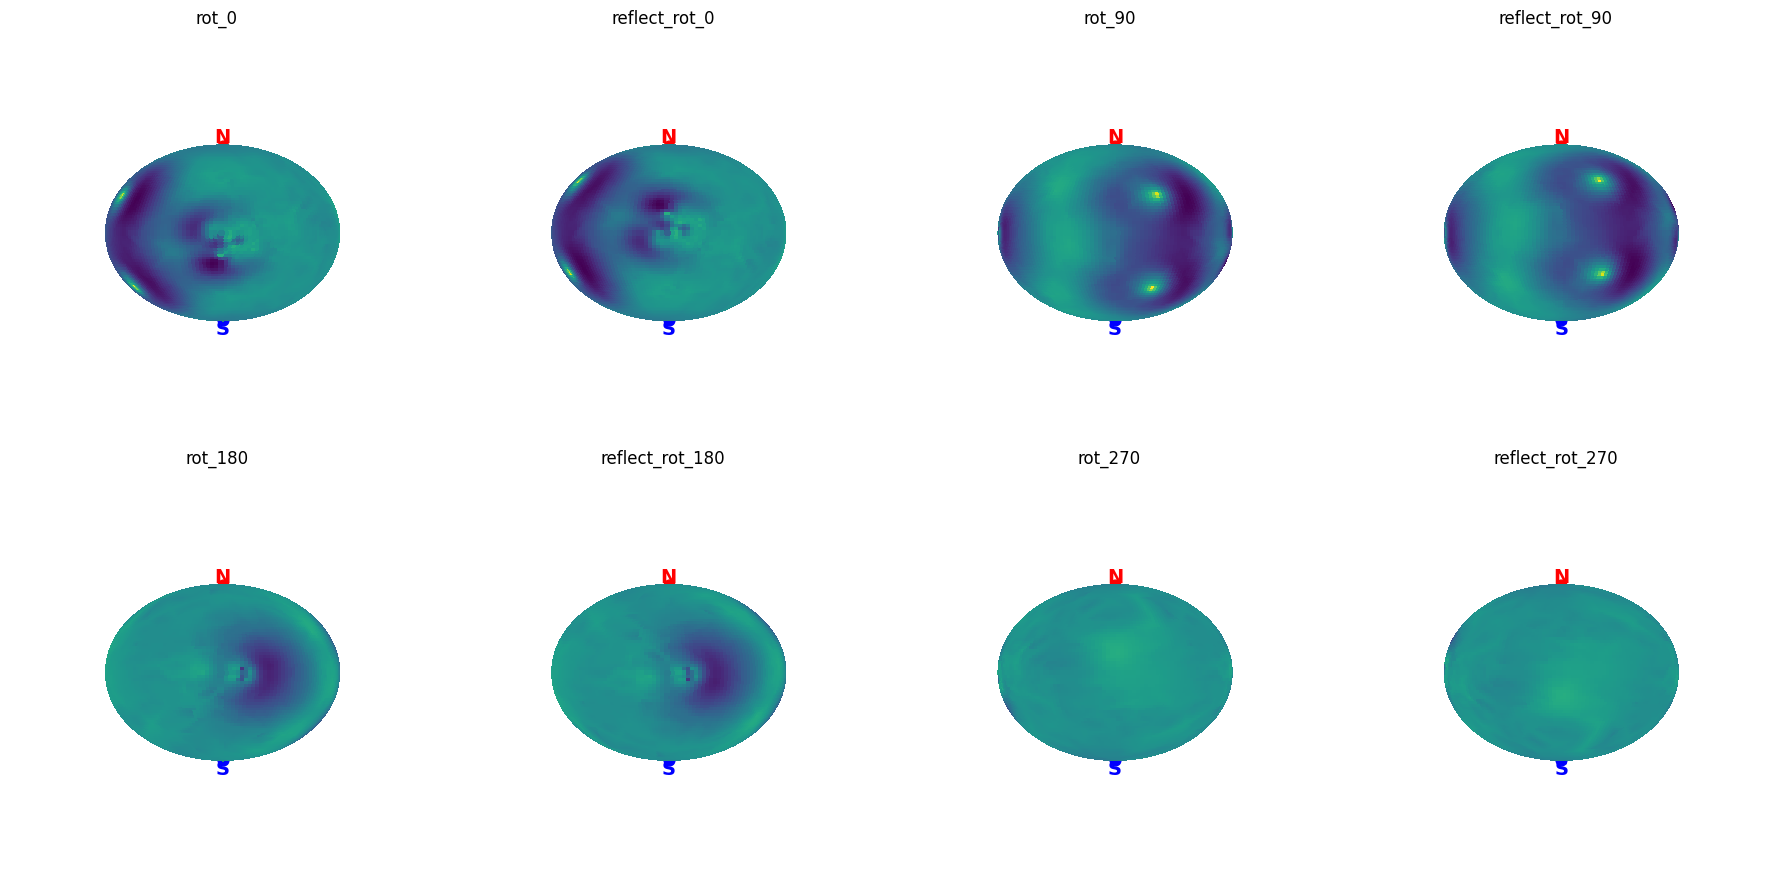

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude
phi = np.linspace(0, 2 * np.pi, W)  # longitude
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# D_n symmetries (n = 4 for 0, 90, 180, 270)
def dn_symmetries(x, n):
    H, W = x.shape
    syms = []
    for k in range(n):
        # Rotation
        rot = np.roll(x, shift=k*W//n, axis=1)
        syms.append((f'rot_{k*360//n}', rot))
        # Reflection + rotation
        refl = np.flip(rot, axis=0)
        syms.append((f'reflect_rot_{k*360//n}', refl))
    return syms

n = 4
syms = dn_symmetries(x, n)

fig = plt.figure(figsize=(18, 9))
for i, (name, x_r) in enumerate(syms):
    ax = fig.add_subplot(2, n, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_r-x_r.min())/(x_r.max()-x_r.min())), rstride=1, cstride=1, antialiased=False, shade=False)
    # Mark north pole (0,0,1) and south pole (0,0,-1)
    ax.scatter([0], [0], [1], color='red', s=60, label='North Pole')
    ax.scatter([0], [0], [-1], color='blue', s=60, label='South Pole')
    ax.text(0, 0, 1.1, 'N', color='red', fontsize=14, ha='center', va='center', weight='bold')
    ax.text(0, 0, -1.1, 'S', color='blue', fontsize=14, ha='center', va='center', weight='bold')
    ax.set_title(name)
    ax.set_axis_off()
    ax.view_init(elev=0, azim=0)  # Side view (equator edge-on)
plt.tight_layout()
plt.show()
